In [1]:
#Imports
import sys
sys.path.append('../python/')
import NGC5533_functions as nf

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import lmfit as lm
import dataPython as dp
import scipy.interpolate as inter

from datetime import datetime
import time as t

In [2]:
starttime = t.time()

data = dp.getXYdata_wXYerr('data/100kpc_data.txt')
r_dat = np.asarray(data['xx'])
v_dat = np.asarray(data['yy'])
v_err0 = np.asarray(data['ex'])
v_err1 = np.asarray(data['ey'])

#for uncertainty band: (form noordermeer's thesis, p.)
delta_i = 3     # guessed value
v_i = (v_dat / np.tan(52*(np.pi/180)) * delta_i *(np.pi/180))




# Uncertainty band


data_greyb_bottom = dp.getXYdata('data/final/nord-120kpc-bottomband.txt')
data_greyb_top = dp.getXYdata('data/final/nord-120kpc-topband.txt')

# convert to numpy arrays
r_bottomband = np.asarray(data_greyb_bottom['xx'])
v_bottomband = np.asarray(data_greyb_bottom['yy'])
r_topband = np.asarray(data_greyb_top['xx'])
v_topband = np.asarray(data_greyb_top['yy'])

band = (v_topband - v_bottomband)/2

# smoothing - new, `spline` would not run on my computer
tb, cb, kb = inter.splrep(r_bottomband,v_bottomband)
tt, ct, kt = inter.splrep(r_topband,   v_topband)

greyb_bottom = inter.BSpline(tb, cb, kb)
greyb_top    = inter.BSpline(tt, ct, kt)

#for weightdata, lengths of v_err1 and band must equal
#make band array same length as v_err1
band = band[0::28] #
band = band[1:]
print(len(v_err1))
print(len(band))


#change r_dat so it's strictly increasing
r_dat, v_dat, v_err0, v_err1 = (np.asarray(list(a)) for a in zip(*sorted(zip(r_dat, v_dat, v_err0, v_err1))))
#converting v_err1 to an array
#v_err1_array = np.asarray(v_err1)


#Express as weights
weighdata = 1/(np.sqrt((v_err1**2)+(band**2)))

69
69


In [3]:
# Function for fitting all parameters (n, re, h)
#def f(r,M,rc,rho00,c,n,re,h,pref):
#    return np.sqrt(nf.bh_v(r,M)**2 
#                   + nf.h_v(r,rc,rho00,load=True)**2 
#                   + c**2*nf.b_v(r,n,reload=True)**2 
#                   + nf.d_v(r,h,pref,load=True)**2)

# Function for fitting only prefactors + halo's parameters
#def g(r,M,rc,rho00,c,pref):
#    return np.sqrt(nf.bh_v(r,M,load=True)**2 
#                   + nf.h_v(r,rc,rho00,load=True)**2 
#                   + c**2*nf.b_v(r,load=True)**2 
#                   + pref**2*nf.d_v(r,load=True)**2)

# Function for fitting only prefactors + halo's parameters + data thief
def g(r,M,rc,rho00,c,pref,gpref):
    return np.sqrt(nf.bh_v(r,M,load=True)**2 
                   + nf.h_v(r,rc,rho00,load=True)**2 
                   + c**2*nf.b_v(r,load=True)**2 
                   + pref**2*nf.d_thief(r)**2
                   + gpref**2*nf.g_thief(r)**2)

#print(g(1,nf.Mbh_def,nf.h_rc,nf.hrho00_c,1,1))
#print(g(5,nf.Mbh_def,nf.h_rc,nf.hrho00_c,1,1))

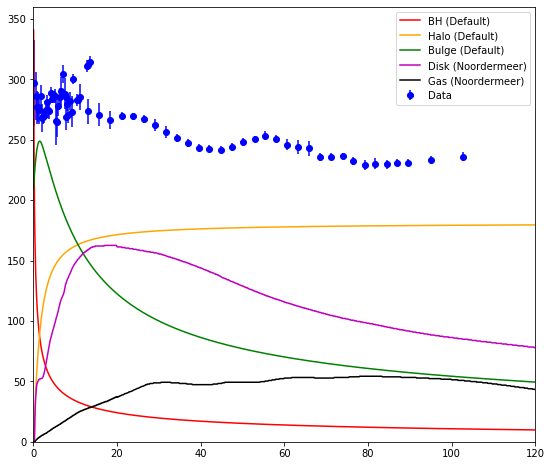

In [4]:
#Plot 

fig = plt.figure(figsize=(9.0,8.0))

plt.xlim(0,120)
plt.ylim(0,360)

rval = np.arange(0.1,200,0.1)

plt.errorbar(r_dat,v_dat,yerr=v_err1,fmt='bo',label='Data')
#plt.plot(rval,g(rval,nf.Mbh_def,nf.h_rc,nf.hrho00_c,1,1,1),label='Total Curve (Default)')
plt.plot(rval,nf.bh_v(rval,load=True),color='r',label='BH (Default)')
plt.plot(rval,nf.h_v(rval,load=True),color='orange',label='Halo (Default)')
plt.plot(rval,nf.b_v(rval,load=True),color='g',label='Bulge (Default)')
#plt.plot(rval,nf.d_v(rval,load=True),color='m',label='Disk (Default)')

plt.plot(rval,nf.d_thief(rval),color='m',label='Disk (Noordermeer)')
plt.plot(rval,nf.g_thief(rval),color='k',label='Gas (Noordermeer)')

plt.legend()
#plt.savefig('Fitting_allcomponents_125kpc.png')
plt.show()

In [5]:
# Fit, using all parameters

#Setup
#l_mod = lm.Model(f)
#l_params = l_mod.make_params()
#Black Hole
#l_params.add('M', value=nf.Mbh_def, min=0) #Mass
#Bulge
#l_params.add('c', value=1, min=0)          #Contributions should all add
#l_params.add('n', value=nf.n_c, min=0)
#l_params.add('re', value=nf.re_c, min=0)
#Disk
#l_params.add('pref', value=nf.pref_def, min=0, max=1000)
#l_params.add('h', value=nf.h_c, min=0, max=1000)
#Halo
#l_params.add('rc', value=nf.h_rc, min=0)   #Radius (magnitude)
#l_params.add('rho00', value=nf.hrho00_c, min=0) #Density (halo)

#Do fit
#l_fit = l_mod.fit(v_dat,l_params,r=r_dat,weights=weighdata)

In [6]:
# Fit, using prefactors

#Setup
g_mod = lm.Model(g)
g_params = g_mod.make_params()
#Black Hole
g_params.add('M', value=nf.Mbh_def, min=1.0e8) #Mass
#Halo
g_params.add('rc', value=nf.h_rc, min=0.1)   #Radius (magnitude)
g_params.add('rho00', value=nf.hrho00_c, min=0) #Density (halo)

#Bulge
g_params.add('c', value=1,min=0,max=100)          #Contributions should all add
#Disk
g_params.add('pref', value=1,min=0, max=100)

#gas
g_params.add('gpref', value=1,min=0, max=100)

#Do fit
g_fit = g_mod.fit(v_dat,g_params,r=r_dat,weights=weighdata)

In [7]:
#Define for plotting

bestg = g_fit.best_fit
delg = g_fit.eval_uncertainty()

In [8]:
#print('Fit information for all-component fit, no prefactor:')
#l_fit

In [9]:
print('Fit information for all-component fit, prefactor:')
g_fit

Fit information for all-component fit, prefactor:


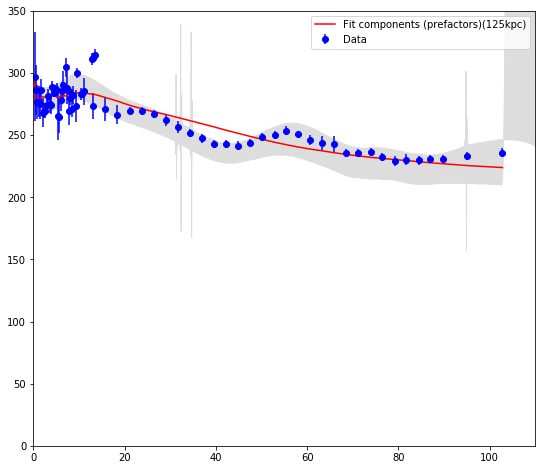

In [10]:
#Plot to 110kpc

fig = plt.figure(figsize=(9.0,8.0))

plt.xlim(0,110)
plt.ylim(0,350)

plt.errorbar(r_dat,v_dat,yerr=v_err1,fmt='bo',label='Data')
#plt.plot(r_dat,l_curve,'b-',label='Fit components (all) (125kpc)')
#plt.plot(rval,g(rval,nf.Mbh_def,nf.h_rc,nf.hrho00_c,1,1,1),label='Total Curve (Default)')
plt.plot(r_dat,bestg,'r-',label='Fit components (prefactors)(125kpc)')
plt.fill_between(rval,greyb_bottom(rval),greyb_top(rval),color='#dddddd')
#plt.fill_between(r_dat,bestg-delg,bestg+delg,color='#dddddd')

plt.legend()
#plt.savefig('Fitting_allcomponents_125kpc.png')
plt.show()

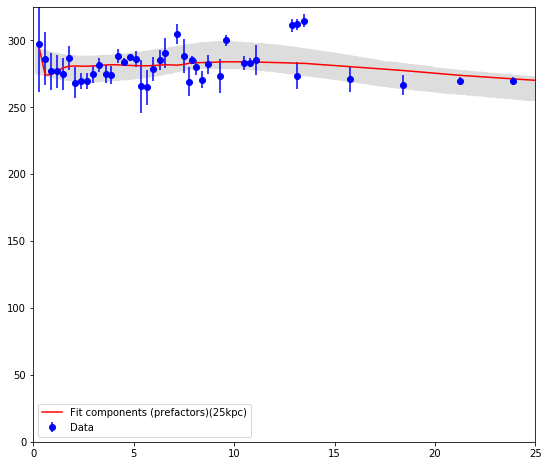

In [11]:
#Plot to 25kpc

fig = plt.figure(figsize=(9.0,8.0))

plt.xlim(0,25)
plt.ylim(0,325)

plt.errorbar(r_dat,v_dat,yerr=v_err1,fmt='bo',label='Data')
#plt.plot(r_dat,l_curve,'b-',label='Fit components (all) (25kpc)')
plt.plot(r_dat,bestg,'r-',label='Fit components (prefactors)(25kpc)')
#plt.fill_between(r_dat,bestg-delg,bestg+delg,color='#dddddd')
plt.fill_between(rval,greyb_bottom(rval),greyb_top(rval),color='#dddddd')
#plt.plot(rval,g(rval,nf.Mbh_def,nf.h_rc,nf.hrho00_c,1,1,1),label='Total Curve (Default)')

plt.legend()
#plt.savefig('Fitting_allcomponents_25kpc.png')
plt.show()

In [12]:
#Define for plotting cont.

g_dict = g_fit.best_values
g_M = g_dict['M']
g_c = g_dict['c']
g_pref = g_dict['pref']
g_rc = g_dict['rc']
g_hrho00 = g_dict['rho00']
g_gpref = g_dict['gpref']

g_curve = g(rval,g_M,g_rc,g_hrho00,g_c,g_pref,g_gpref)
bh_curve = nf.bh_v(rval,g_M)
halo_curve = nf.h_v(rval,g_rc,g_hrho00)
bulge_curve = g_c*nf.b_v(rval, load=True)
#disk_curve = g_pref*nf.d_v(rval, load=True)
disk_curve = g_pref*nf.d_thief(rval)
gas_curve = g_gpref*nf.g_thief(rval)

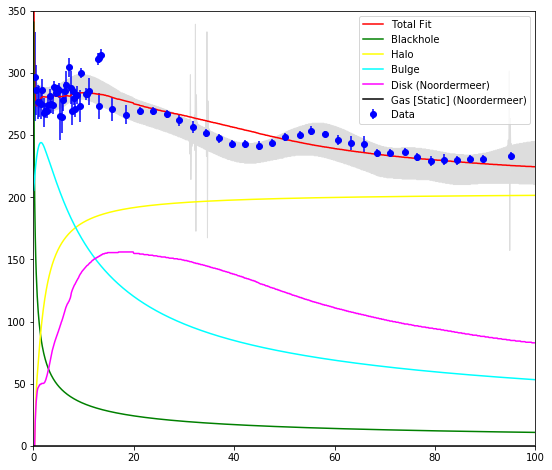

In [13]:
#Plot each fitted component to 100kpc

fig = plt.figure(figsize=(9.0,8.0))

plt.xlim(0,100)
plt.ylim(0,350)
plt.plot(rval,g_curve,'r-',label='Total Fit')
plt.errorbar(r_dat,v_dat,yerr=v_err1,fmt='bo',label='Data')
#plt.plot(r_dat,l_curve,'b-',label='Fit components (all) (25kpc)')


#plt.fill_between(r_dat,bestg-delg,bestg+delg,color='#dddddd',label='Uncertainty Band')
plt.plot(rval,bh_curve,'green',label='Blackhole')
plt.plot(rval,halo_curve,'yellow',label='Halo')
plt.plot(rval,bulge_curve,'cyan',label='Bulge')
plt.plot(rval,disk_curve,'magenta',label='Disk (Noordermeer)')
plt.plot(rval,gas_curve,'black',label='Gas [Static] (Noordermeer)')
plt.fill_between(rval,greyb_bottom(rval),greyb_top(rval),color='#dddddd')


#plt.plot(rval,g(rval,nf.Mbh_def,nf.h_rc,nf.hrho00_c,1,1,1),label='Total Curve (Default)')

plt.legend()
#plt.savefig('Fitting_allcomponents_100kpc.png')
plt.show()

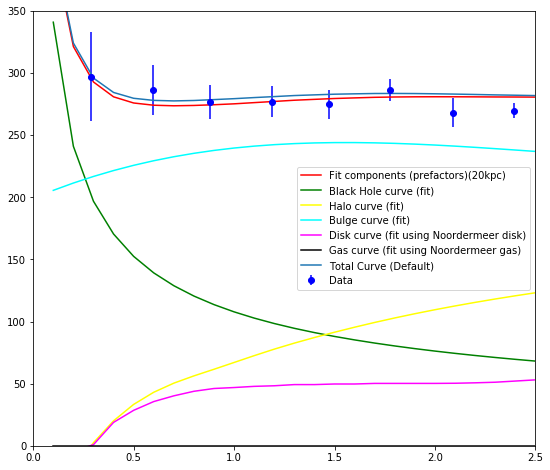

In [14]:
#Plot each fitted component to 20kpc

fig = plt.figure(figsize=(9.0,8.0))

plt.xlim(0,2.5)
plt.ylim(0,350)

plt.errorbar(r_dat,v_dat,yerr=v_err1,fmt='bo',label='Data')
#plt.plot(r_dat,l_curve,'b-',label='Fit components (all) (25kpc)')

plt.plot(rval,g_curve,'r-',label='Fit components (prefactors)(20kpc)')
plt.plot(rval,bh_curve,'green',label='Black Hole curve (fit)')
plt.plot(rval,halo_curve,'yellow',label='Halo curve (fit)')
plt.plot(rval,bulge_curve,'cyan',label='Bulge curve (fit)')
plt.plot(rval,disk_curve,'magenta',label='Disk curve (fit using Noordermeer disk)')
plt.plot(rval,gas_curve,'black',label='Gas curve (fit using Noordermeer gas)')

plt.plot(rval,g(rval,nf.Mbh_def,nf.h_rc,nf.hrho00_c,1,1,1),label='Total Curve (Default)')

plt.legend()
#plt.savefig('Fitting_allcomponents_20kpc.png')
plt.show()

In [15]:
# Explanation of parameters 

# Bulge
print('Bulge')
print('Scaling constant,         C = {:.2f}'.format(g_c))

print('')


# Disk
print('Disk')
print('Scaling constant,         prefactor = {:.3f}'.format(g_pref))

print('')


# Black Hole
print('Black Hole')
print('Mass of the Black Hole,   M(bh) = {:.3e} [solar masses]'.format(g_M))
print('')


# Dark Halo
print('Dark Halo')
print('Halo central density,     rho00 = {:.3e} [solar mass/kpc^3]'.format(g_hrho00))
print('Core radius,              rc = {:.2f} [kpc]'.format(g_rc))


Bulge
Scaling constant,         C = 0.98

Disk
Scaling constant,         prefactor = 0.960

Black Hole
Mass of the Black Hole,   M(bh) = 2.702e+09 [solar masses]

Dark Halo
Halo central density,     rho00 = 3.100e+08 [solar mass/kpc^3]
Core radius,              rc = 1.58 [kpc]


In [16]:
endtime = t.time()     #put this at end of code
print('Total Time:')
runtime = endtime - starttime

if runtime<=60:
    minutes, runtime= divmod(runtime, 60)
    print(str(round(runtime))+'s')
elif runtime>60 and runtime<=3600:
    minutes, runtime= divmod(runtime, 60)
    print(str(round(minutes))+'min', str(round(runtime))+'s')
elif runtime>3600 and runtime<=86400:
    minutes = runtime/60
    hours, minutes= divmod(minutes, 60)
    print(str(round(hours))+'hrs', str(round(minutes))+'min')
elif runtime>86400:
    hours = runtime/3600
    days, hours= divmod(hours, 24)
    print(str(round(days))+'days', str(round(hours))+'hrs')

Total Time:
9s
